In [ ]:
#!/usr/bin/env python3
"""
Extract point cloud and paths from ROS2 bag files (using only the last message from each topic),
export to a GLB file, and display it in an IPython Notebook.

The point cloud is simulated as a set of small boxes (with adjustable size)
colored in grayscale based on their z height.
Path1 is colored red and path2 is colored blue.
If the point cloud is too large, it will be subsampled to avoid overloading the system.
Ground points (with z below a threshold) are removed for a cleaner point cloud.
"""

import numpy as np
import trimesh
import rosbag2_py
from rclpy.serialization import deserialize_message  # Updated import for ROS2 Humble
from sensor_msgs.msg import PointCloud2
from nav_msgs.msg import Path
import sensor_msgs_py.point_cloud2 as pc2

# For displaying in an IPython Notebook
from IPython.display import HTML, display

def extract_point_cloud(bag_path, topic):
    """Extract the point cloud data (x, y, z) from only the last message in the bag file for the given topic."""
    reader = rosbag2_py.SequentialReader()
    storage_options = rosbag2_py.StorageOptions(uri=bag_path, storage_id='sqlite3')
    converter_options = rosbag2_py.ConverterOptions(
        input_serialization_format='cdr',
        output_serialization_format='cdr'
    )
    reader.open(storage_options, converter_options)

    last_data = None
    while reader.has_next():
        topic_name, data, t = reader.read_next()
        if topic_name == topic:
            last_data = data
    if last_data is None:
        return np.array([])

    msg = deserialize_message(last_data, PointCloud2)
    points = []
    for p in pc2.read_points(msg, skip_nans=True, field_names=("x", "y", "z")):
        points.append(p)
    return np.array(points)

def extract_path(bag_path, topic):
    """Extract the path (as a set of poses) from only the last message from the bag file for the given topic."""
    reader = rosbag2_py.SequentialReader()
    storage_options = rosbag2_py.StorageOptions(uri=bag_path, storage_id='sqlite3')
    converter_options = rosbag2_py.ConverterOptions(
        input_serialization_format='cdr',
        output_serialization_format='cdr'
    )
    reader.open(storage_options, converter_options)

    last_data = None
    while reader.has_next():
        topic_name, data, t = reader.read_next()
        if topic_name == topic:
            last_data = data
    if last_data is None:
        return np.array([])

    msg = deserialize_message(last_data, Path)
    path_points = []
    for pose_stamped in msg.poses:
        pos = pose_stamped.pose.position
        path_points.append([pos.x, pos.y, pos.z])
    return np.array(path_points)

def create_path_cylinders(path_points, radius=0.05):
    """
    Create a single mesh that represents the path as a series of cylinders
    connecting consecutive waypoints.
    """
    cylinders = []
    for i in range(len(path_points) - 1):
        start = path_points[i]
        end = path_points[i + 1]
        vec = end - start
        length = np.linalg.norm(vec)
        if length == 0:
            continue
        # Create a cylinder along the Z axis (centered at origin)
        cyl = trimesh.creation.cylinder(radius=radius, height=length, sections=12)
        # Align the cylinder with the vector from start to end.
        z_axis = np.array([0, 0, 1])
        direction = vec / length
        rotation, _ = trimesh.geometry.align_vectors(z_axis, direction, return_angle=True)
        T = trimesh.transformations.translation_matrix((start + end) / 2)
        transform = trimesh.transformations.concatenate_matrices(T, rotation)
        cyl.apply_transform(transform)
        cylinders.append(cyl)
    if cylinders:
        return trimesh.util.concatenate(cylinders)
    else:
        return None

def create_point_cloud_mesh(points, colors, point_size=0.02):
    """
    Create a mesh representing the point cloud by instancing a small box
    at each point.
    
    Args:
      points (Nx3 array): XYZ coordinates.
      colors (Nx4 array): RGBA colors for each point (values in 0-255).
      point_size (float): Edge length of the box representing each point.
    
    Returns:
      A trimesh.Trimesh object containing all the box instances.
    """
    # Create a box template centered at the origin.
    box = trimesh.creation.box(extents=[point_size, point_size, point_size])
    meshes = []
    for pt, color in zip(points, colors):
        instance = box.copy()
        instance.visual.face_colors = color
        instance.apply_translation(pt)
        meshes.append(instance)
    return trimesh.util.concatenate(meshes)

def display_glb(glb_filename):
    """Display the GLB file in an IPython Notebook using <model-viewer>."""
    html_code = f"""
    <script type="module" src="https://unpkg.com/@google/model-viewer/dist/model-viewer.min.js"></script>
    <model-viewer src="{glb_filename}" alt="3D model" auto-rotate camera-controls style="width: 800px; height: 600px;"></model-viewer>
    """
    display(HTML(html_code))

def main():
    # Define bag file paths and corresponding topics
    pc_bag    = "/media/raghuram/Untitled/data/bags/gq_full_map_pc"
    pc_topic  = "/quadrotor/nvblox_node/static_occupancy"
    path1_bag = "/media/raghuram/Untitled/paths_waypoints/gq_path"
    path1_topic = "/quadrotor/des_path"
    path2_bag = "/media/raghuram/Untitled/bags/ros2_bags/gq_map_ros2"
    path2_topic = "/visualizer/trajectory_path"

    # Adjustable parameters
    point_size = 0.3
    max_points = 50000  # Limit the number of point cloud boxes to process
    ground_threshold = 0.3  # Remove points with z <= ground_threshold

    print("Extracting point cloud from:", pc_bag)
    points = extract_point_cloud(pc_bag, pc_topic)
    print(f"Extracted {points.shape[0]} points from the last message.")

    # Convert structured array to a regular (N,3) float64 array if needed.
    if points.size > 0 and points.dtype.names is not None:
        points = np.stack((points['x'], points['y'], points['z']), axis=-1).astype(np.float64)

    # Subsample the points if there are too many.
    if points.shape[0] > max_points:
        indices = np.random.choice(points.shape[0], max_points, replace=False)
        points = points[indices]
        print(f"Subsampled to {points.shape[0]} points.")
    
    # Remove ground points (those with z value below the threshold)
    if points.size > 0:
        points = points[points[:,2] > ground_threshold]
        print(f"After ground removal, {points.shape[0]} points remain.")

    print("Extracting path1 from:", path1_bag)
    path1_points = extract_path(path1_bag, path1_topic)
    print(f"Extracted {path1_points.shape[0]} waypoints for path1 from the last message.")

    print("Extracting path2 from:", path2_bag)
    path2_points = extract_path(path2_bag, path2_topic)
    print(f"Extracted {path2_points.shape[0]} waypoints for path2 from the last message.")

    # Build a trimesh scene to hold all geometry.
    scene = trimesh.Scene()

    # Create and add the point cloud mesh with grayscale intensity based on z height.
    if points.size > 0:
        z = points[:, 2]
        z_min = np.min(z)
        z_max = np.max(z)
        if np.abs(z_max - z_min) < 1e-6:
            normalized = np.zeros_like(z)
        else:
            normalized = (z - z_min) / (z_max - z_min)
        # Compute grayscale colors; adjust the range if needed.
        grayscale = (normalized * 255).astype(np.uint8)
        colors = np.stack((grayscale, grayscale, grayscale, np.full_like(grayscale, 255)), axis=1)
        # Create a mesh from points using small boxes.
        point_cloud_mesh = create_point_cloud_mesh(points, colors, point_size=point_size)
        scene.add_geometry(point_cloud_mesh, node_name='point_cloud')
    
    # Create and add path geometries if available.
    if path1_points.shape[0] > 1:
        path1_mesh = create_path_cylinders(path1_points, radius=0.3)
        if path1_mesh is not None:
            # Color path1 in red (RGBA)
            path1_mesh.visual.face_colors = [255, 0, 0, 255]
            scene.add_geometry(path1_mesh, node_name='path1')
    if path2_points.shape[0] > 1:
        path2_mesh = create_path_cylinders(path2_points, radius=0.3)
        if path2_mesh is not None:
            # Color path2 in light blue (RGBA)
            path2_mesh.visual.face_colors = [0, 0, 230, 255]
            scene.add_geometry(path2_mesh, node_name='path2')
    
    # Export the scene to a GLB (glTF binary) file.
    output_file = "/media/raghuram/Untitled/glb/output_gq.glb"
    scene.export(output_file)
    print(f"Scene exported successfully to {output_file}")

    # Display the GLB in the IPython Notebook.
    display_glb(output_file)#!/usr/bin/env python3



if __name__ == "__main__":
    main()


Extracting point cloud from: /media/raghuram/Untitled/data/bags/gq_full_map_pc


[INFO] [1744044875.115794737] [rosbag2_storage]: Opened database '/media/raghuram/Untitled/data/bags/gq_full_map_pc/rosbag2_2025_03_10-17_58_24_0.db3' for READ_ONLY.


Extracted 74846 points from the last message.
Subsampled to 40000 points.
After ground removal, 12596 points remain.
Extracting path1 from: /media/raghuram/Untitled/paths_waypoints/gq_path
Extracted 5600 waypoints for path1 from the last message.
Extracting path2 from: /media/raghuram/Untitled/bags/ros2_bags/gq_map_ros2


[INFO] [1744044875.424500571] [rosbag2_storage]: Opened database '/media/raghuram/Untitled/paths_waypoints/gq_path/rosbag2_2025_04_03-17_42_58_0.db3' for READ_ONLY.
[INFO] [1744044875.613108270] [rosbag2_storage]: Opened database '/media/raghuram/Untitled/bags/ros2_bags/gq_map_ros2/gq_map_ros2.db3' for READ_ONLY.


Extracted 3882 waypoints for path2 from the last message.
Scene exported successfully to /media/raghuram/Untitled/glb/output_gq.glb


Extracting point cloud from: /media/raghuram/Untitled/data/bags/gq_full_map_pc


[INFO] [1744044881.044354960] [rosbag2_storage]: Opened database '/media/raghuram/Untitled/data/bags/gq_full_map_pc/rosbag2_2025_03_10-17_58_24_0.db3' for READ_ONLY.


Extracted 74846 points from the last message.
Subsampled to 40000 points.
After ground removal, 12607 points remain.
Extracting path1 from: /media/raghuram/Untitled/paths_waypoints/gq_path
Extracted 5600 waypoints for path1 from the last message.
Extracting path2 from: /media/raghuram/Untitled/bags/ros2_bags/gq_map_ros2


[INFO] [1744044881.310932981] [rosbag2_storage]: Opened database '/media/raghuram/Untitled/paths_waypoints/gq_path/rosbag2_2025_04_03-17_42_58_0.db3' for READ_ONLY.
[INFO] [1744044881.485539019] [rosbag2_storage]: Opened database '/media/raghuram/Untitled/bags/ros2_bags/gq_map_ros2/gq_map_ros2.db3' for READ_ONLY.


Extracted 3882 waypoints for path2 from the last message.
Scene exported successfully to /media/raghuram/Untitled/glb/output_gq.glb


In [16]:
#!/usr/bin/env python3
"""
Extract point cloud and paths from ROS2 bag files (using only the last message from each topic),
export to a GLB file, and display it in an IPython Notebook.

The point cloud is simulated as a set of small boxes (with adjustable size)
colored in grayscale based on their z height.
Path1 is colored red and path2 is colored light blue.
If the point cloud is too large, it will be subsampled to avoid overloading the system.
"""

import numpy as np
import trimesh
import rosbag2_py
from rclpy.serialization import deserialize_message  # Updated import for ROS2 Humble
from sensor_msgs.msg import PointCloud2
from nav_msgs.msg import Path
import sensor_msgs_py.point_cloud2 as pc2

# For displaying in an IPython Notebook
from IPython.display import HTML, display

def extract_point_cloud(bag_path, topic):
    """Extract the point cloud data (x, y, z) from only the last message in the bag file for the given topic."""
    reader = rosbag2_py.SequentialReader()
    storage_options = rosbag2_py.StorageOptions(uri=bag_path, storage_id='sqlite3')
    converter_options = rosbag2_py.ConverterOptions(
        input_serialization_format='cdr',
        output_serialization_format='cdr'
    )
    reader.open(storage_options, converter_options)
    
    last_data = None
    while reader.has_next():
        topic_name, data, t = reader.read_next()
        if topic_name == topic:
            last_data = data
    if last_data is None:
        return np.array([])
    
    msg = deserialize_message(last_data, PointCloud2)
    points = []
    for p in pc2.read_points(msg, skip_nans=True, field_names=("x", "y", "z")):
        points.append(p)
    return np.array(points)

def extract_path(bag_path, topic):
    """Extract the path (as a set of poses) from only the last message in the bag file for the given topic."""
    reader = rosbag2_py.SequentialReader()
    storage_options = rosbag2_py.StorageOptions(uri=bag_path, storage_id='sqlite3')
    converter_options = rosbag2_py.ConverterOptions(
        input_serialization_format='cdr',
        output_serialization_format='cdr'
    )
    reader.open(storage_options, converter_options)
    
    last_data = None
    while reader.has_next():
        topic_name, data, t = reader.read_next()
        if topic_name == topic:
            last_data = data
    if last_data is None:
        return np.array([])
    
    msg = deserialize_message(last_data, Path)
    path_points = []
    for pose_stamped in msg.poses:
        pos = pose_stamped.pose.position
        path_points.append([pos.x, pos.y, pos.z])
    return np.array(path_points)

def create_path_cylinders(path_points, radius=0.05):
    """
    Create a single mesh that represents the path as a series of cylinders
    connecting consecutive waypoints.
    """
    cylinders = []
    for i in range(len(path_points) - 1):
        start = path_points[i]
        end = path_points[i + 1]
        vec = end - start
        length = np.linalg.norm(vec)
        if length == 0:
            continue
        # Create a cylinder along the Z axis (centered at origin)
        cyl = trimesh.creation.cylinder(radius=radius, height=length, sections=12)
        # Align the cylinder with the vector from start to end.
        z_axis = np.array([0, 0, 1])
        direction = vec / length
        # Get rotation matrix that aligns z_axis with our direction.
        rotation, _ = trimesh.geometry.align_vectors(z_axis, direction, return_angle=True)
        # Compute translation so that the cylinder is centered between start and end.
        T = trimesh.transformations.translation_matrix((start + end) / 2)
        # Combine rotation and translation.
        transform = trimesh.transformations.concatenate_matrices(T, rotation)
        cyl.apply_transform(transform)
        cylinders.append(cyl)
    if cylinders:
        return trimesh.util.concatenate(cylinders)
    else:
        return None

def create_point_cloud_mesh(points, colors, point_size=0.02):
    """
    Create a mesh representing the point cloud by instancing a small box at each point.
    
    Args:
      points (Nx3 array): XYZ coordinates.
      colors (Nx4 array): RGBA colors for each point (values in 0-255).
      point_size (float): Edge length of the box representing each point.
    
    Returns:
      A trimesh.Trimesh object containing all the box instances.
    """
    # Create a box template.
    # The box is centered at the origin.
    box = trimesh.creation.box(extents=[point_size, point_size, point_size])
    meshes = []
    for pt, color in zip(points, colors):
        instance = box.copy()
        instance.visual.face_colors = color
        instance.apply_translation(pt)
        meshes.append(instance)
    return trimesh.util.concatenate(meshes)

def display_glb(glb_filename):
    """Display the GLB file in an IPython Notebook using <model-viewer>."""
    html_code = f"""
    <script type="module" src="https://unpkg.com/@google/model-viewer/dist/model-viewer.min.js"></script>
    <model-viewer src="{glb_filename}" alt="3D model" auto-rotate camera-controls style="width: 800px; height: 600px;"></model-viewer>
    """
    display(HTML(html_code))

def main():
    # Define bag file paths and corresponding topics
    pc_bag    = "/media/raghuram/Untitled/data/bags/minco_map"
    pc_topic  = "/voxel_map"
    path1_bag = "/media/raghuram/Untitled/paths_waypoints/minco_path_bag"
    path1_topic = "/quadrotor/des_path"
    path2_bag = "/media/raghuram/Untitled/bags/ros2_bags/minco_map_ros2"
    path2_topic = "/visualizer/trajectory_path"

    # Adjustable parameters
    point_size = 0.5  # Edge length of each box
    max_points = 50000  # Limit the number of point cloud boxes to process

    print("Extracting point cloud from:", pc_bag)
    points = extract_point_cloud(pc_bag, pc_topic)
    print(f"Extracted {points.shape[0]} points from the last message.")

    # Convert structured array to a regular (N,3) float64 array if needed.
    if points.size > 0 and points.dtype.names is not None:
        points = np.stack((points['x'], points['y'], points['z']), axis=-1).astype(np.float64)

    # Subsample the points if there are too many
    if points.shape[0] > max_points:
        indices = np.random.choice(points.shape[0], max_points, replace=False)
        points = points[indices]
        print(f"Subsampled to {points.shape[0]} points.")

    print("Extracting path1 from:", path1_bag)
    path1_points = extract_path(path1_bag, path1_topic)
    print(f"Extracted {path1_points.shape[0]} waypoints for path1 from the last message.")

    print("Extracting path2 from:", path2_bag)
    path2_points = extract_path(path2_bag, path2_topic)
    print(f"Extracted {path2_points.shape[0]} waypoints for path2 from the last message.")

    # Build a trimesh scene to hold all geometry.
    scene = trimesh.Scene()

    # Create and add the point cloud mesh with grayscale intensity based on z height.
    if points.size > 0:
        z = points[:, 2]
        z_min = np.min(z)
        z_max = np.max(z)
        if np.abs(z_max - z_min) < 1e-6:
            normalized = np.zeros_like(z)
        else:
            normalized = (z - z_min) / (z_max - z_min)
        # Compute grayscale colors: same value for R, G, and B.
        grayscale = (normalized * 255 - 15).astype(np.uint8)
        colors = np.stack((grayscale, grayscale, grayscale, np.full_like(grayscale, 255)), axis=1)
        # Create a mesh from points using small boxes.
        point_cloud_mesh = create_point_cloud_mesh(points, colors, point_size=point_size)
        scene.add_geometry(point_cloud_mesh, node_name='point_cloud')
    
    # Create and add path geometries if available.
    if path1_points.shape[0] > 1:
        path1_mesh = create_path_cylinders(path1_points, radius=0.3)
        if path1_mesh is not None:
            # Color path1 in red (RGBA)
            path1_mesh.visual.face_colors = [255, 0, 0, 255]
            scene.add_geometry(path1_mesh, node_name='path1')
    if path2_points.shape[0] > 1:
        path2_mesh = create_path_cylinders(path2_points, radius=0.3)
        if path2_mesh is not None:
            # Color path2 in light blue (RGBA)
            path2_mesh.visual.face_colors = [0, 0, 255, 255]
            scene.add_geometry(path2_mesh, node_name='path2')

    # Export the scene to a GLB (glTF binary) file.
    output_file = "/media/raghuram/Untitled/glb/output_minco.glb"
    scene.export(output_file)
    print(f"Scene exported successfully to {output_file}")

    # Display the GLB in the IPython Notebook.
    display_glb(output_file)

if __name__ == "__main__":
    main()


Extracting point cloud from: /media/raghuram/Untitled/data/bags/minco_map


[INFO] [1744044693.638679210] [rosbag2_storage]: Opened database '/media/raghuram/Untitled/data/bags/minco_map/minco_map.db3' for READ_ONLY.


Extracted 239999 points from the last message.
Subsampled to 50000 points.
Extracting path1 from: /media/raghuram/Untitled/paths_waypoints/minco_path_bag
Extracted 5580 waypoints for path1 from the last message.
Extracting path2 from: /media/raghuram/Untitled/bags/ros2_bags/minco_map_ros2


[INFO] [1744044694.077043453] [rosbag2_storage]: Opened database '/media/raghuram/Untitled/paths_waypoints/minco_path_bag/rosbag2_2025_04_02-15_11_18_0.db3' for READ_ONLY.
[INFO] [1744044694.208561771] [rosbag2_storage]: Opened database '/media/raghuram/Untitled/bags/ros2_bags/minco_map_ros2/minco_map_ros2.db3' for READ_ONLY.


Extracted 3450 waypoints for path2 from the last message.
Scene exported successfully to /media/raghuram/Untitled/glb/output_minco.glb


In [21]:
#!/usr/bin/env python3
"""
Extract point cloud and paths from ROS2 bag files (using only the last message from each topic),
export to a GLB file, and display it in an IPython Notebook.

The point cloud is simulated as a set of small spheres (with adjustable size)
colored in grayscale based on their z height.
Path1 is colored red and path2 is colored blue.
If the point cloud is too large, it will be subsampled to avoid overloading the system.

Additionally, we remove points above a certain z-height to 'cut off the roof'.
"""

import numpy as np
import trimesh
import rosbag2_py
from rclpy.serialization import deserialize_message  # Updated import for ROS2 Humble
from sensor_msgs.msg import PointCloud2
from nav_msgs.msg import Path
import sensor_msgs_py.point_cloud2 as pc2

# For displaying in an IPython Notebook
from IPython.display import HTML, display

def extract_point_cloud(bag_path, topic):
    """Extract the point cloud data (x, y, z) from only the last message in the bag file for the given topic."""
    reader = rosbag2_py.SequentialReader()
    storage_options = rosbag2_py.StorageOptions(uri=bag_path, storage_id='sqlite3')
    converter_options = rosbag2_py.ConverterOptions(
        input_serialization_format='cdr',
        output_serialization_format='cdr'
    )
    reader.open(storage_options, converter_options)
    
    last_data = None
    while reader.has_next():
        topic_name, data, t = reader.read_next()
        if topic_name == topic:
            last_data = data
    if last_data is None:
        return np.array([])
    
    msg = deserialize_message(last_data, PointCloud2)
    points = []
    for p in pc2.read_points(msg, skip_nans=True, field_names=("x", "y", "z")):
        points.append(p)
    return np.array(points)

def extract_path(bag_path, topic):
    """Extract the path (as a set of poses) from only the last message in the bag file for the given topic."""
    reader = rosbag2_py.SequentialReader()
    storage_options = rosbag2_py.StorageOptions(uri=bag_path, storage_id='sqlite3')
    converter_options = rosbag2_py.ConverterOptions(
        input_serialization_format='cdr',
        output_serialization_format='cdr'
    )
    reader.open(storage_options, converter_options)
    
    last_data = None
    while reader.has_next():
        topic_name, data, t = reader.read_next()
        if topic_name == topic:
            last_data = data
    if last_data is None:
        return np.array([])
    
    msg = deserialize_message(last_data, Path)
    path_points = []
    for pose_stamped in msg.poses:
        pos = pose_stamped.pose.position
        path_points.append([pos.x, pos.y, pos.z])
    return np.array(path_points)

def create_path_cylinders(path_points, radius=0.05):
    """
    Create a single mesh that represents the path as a series of cylinders
    connecting consecutive waypoints.
    """
    cylinders = []
    for i in range(len(path_points) - 1):
        start = path_points[i]
        end = path_points[i + 1]
        vec = end - start
        length = np.linalg.norm(vec)
        if length == 0:
            continue
        # Create a cylinder along the Z axis (centered at origin)
        cyl = trimesh.creation.cylinder(radius=radius, height=length, sections=12)
        # Align the cylinder with the vector from start to end.
        z_axis = np.array([0, 0, 1])
        direction = vec / length
        # Get rotation matrix that aligns z_axis with our direction.
        rotation, _ = trimesh.geometry.align_vectors(z_axis, direction, return_angle=True)
        # Compute translation so that the cylinder is centered between start and end.
        T = trimesh.transformations.translation_matrix((start + end) / 2)
        # Combine rotation and translation.
        transform = trimesh.transformations.concatenate_matrices(T, rotation)
        cyl.apply_transform(transform)
        cylinders.append(cyl)
    if cylinders:
        return trimesh.util.concatenate(cylinders)
    else:
        return None

def create_point_cloud_mesh(points, colors, point_size=0.02):
    """
    Create a mesh representing the point cloud by instancing a small sphere
    at each point.
    
    Args:
      points (Nx3 array): XYZ coordinates.
      colors (Nx4 array): RGBA colors for each point (values in 0-255).
      point_size (float): Radius of the sphere representing each point.
    
    Returns:
      A trimesh.Trimesh object containing all the sphere instances.
    """
    # Create a sphere template.
    box = trimesh.creation.box(extents=[point_size, point_size, point_size])
    meshes = []
    for pt, color in zip(points, colors):
        instance = box.copy()
        instance.visual.face_colors = color
        instance.apply_translation(pt)
        meshes.append(instance)
    return trimesh.util.concatenate(meshes)

def display_glb(glb_filename):
    """Display the GLB file in an IPython Notebook using <model-viewer>."""
    html_code = f"""
    <script type="module" src="https://unpkg.com/@google/model-viewer/dist/model-viewer.min.js"></script>
    <model-viewer src="{glb_filename}" alt="3D model" auto-rotate camera-controls style="width: 800px; height: 600px;"></model-viewer>
    """
    display(HTML(html_code))

def main():
    # Define bag file paths and corresponding topics
    pc_bag    = "/media/raghuram/Untitled/data/bags/hospital_map"
    pc_topic  = "/occupancy_map/inflated_voxel_map"
    path1_bag = "/media/raghuram/Untitled/paths_waypoints/hospital_path_bag"
    path1_topic = "/quadrotor/des_path"
    path2_bag = "/media/raghuram/Untitled/bags/ros2_bags/hospital_map_ros2"
    path2_topic = "/visualizer/trajectory_path"

    # Adjustable parameters
    point_size = 0.5
    max_points = 50000  # Limit the number of point cloud spheres to process
    
    # This is the z-threshold above which we'll remove points ("cut off the roof").
    # Adjust this value as needed.
    max_z_threshold = 1.5

    print("Extracting point cloud from:", pc_bag)
    points = extract_point_cloud(pc_bag, pc_topic)
    print(f"Extracted {points.shape[0]} points from the last message.")

    # Convert structured array to a regular (N,3) float64 array if needed.
    if points.size > 0 and points.dtype.names is not None:
        points = np.stack((points['x'], points['y'], points['z']), axis=-1).astype(np.float64)

    # Remove any points above the specified z threshold
    if points.size > 0:
        before_filter_count = points.shape[0]
        points = points[points[:, 2] < max_z_threshold]
        after_filter_count = points.shape[0]
        print(f"Removed {before_filter_count - after_filter_count} points above z={max_z_threshold}.")
        print(f"{after_filter_count} points remain.")

    # Subsample the points if there are too many
    if points.shape[0] > max_points:
        indices = np.random.choice(points.shape[0], max_points, replace=False)
        points = points[indices]#!/usr/bin/env python3

        print(f"Subsampled to {points.shape[0]} points.")

    print("Extracting path1 from:", path1_bag)
    path1_points = extract_path(path1_bag, path1_topic)
    print(f"Extracted {path1_points.shape[0]} waypoints for path1 from the last message.")

    print("Extracting path2 from:", path2_bag)
    path2_points = extract_path(path2_bag, path2_topic)
    print(f"Extracted {path2_points.shape[0]} waypoints for path2 from the last message.")

    # Build a trimesh scene to hold all geometry.
    scene = trimesh.Scene()

    # Create and add the point cloud mesh with grayscale intensity based on z height.
    if points.size > 0:
        z = points[:, 2]
        z_min = np.min(z)
        z_max = np.max(z)
        if np.abs(z_max - z_min) < 1e-6:
            normalized = np.zeros_like(z)
        else:
            normalized = (z - z_min) / (z_max - z_min)
        # Compute grayscale colors: same value for R, G, and B.
        grayscale = (normalized * 255).astype(np.uint8)
        colors = np.stack((grayscale, grayscale, grayscale, np.full_like(grayscale, 255)), axis=1)
        # Create a mesh from points using small spheres.
        point_cloud_mesh = create_point_cloud_mesh(points, colors, point_size=point_size)
        scene.add_geometry(point_cloud_mesh, node_name='point_cloud')
    
    # Create and add path geometries if available.
    if path1_points.shape[0] > 1:
        path1_mesh = create_path_cylinders(path1_points, radius=0.3)
        if path1_mesh is not None:
            # Color path1 in red (RGBA)
            path1_mesh.visual.face_colors = [255, 0, 0, 255]
            scene.add_geometry(path1_mesh, node_name='path1')
    if path2_points.shape[0] > 1:
        path2_mesh = create_path_cylinders(path2_points, radius=0.3)
        if path2_mesh is not None:
            # Color path2 in blue (RGBA)
            path2_mesh.visual.face_colors = [0, 0, 255, 255]
            scene.add_geometry(path2_mesh, node_name='path2')

    # Export the scene to a GLB (glTF binary) file.
    output_file = "/media/raghuram/Untitled/glb/output_hospital.glb"
    scene.export(output_file)
    print(f"Scene exported successfully to {output_file}")

    # Display the GLB in the IPython Notebook.
    display_glb(output_file)

if __name__ == "__main__":
    main()


Extracting point cloud from: /media/raghuram/Untitled/data/bags/hospital_map


[INFO] [1744045511.836170528] [rosbag2_storage]: Opened database '/media/raghuram/Untitled/data/bags/hospital_map/hospital_map.db3' for READ_ONLY.


Extracted 733204 points from the last message.
Removed 347265 points above z=1.5.
385939 points remain.
Subsampled to 50000 points.
Extracting path1 from: /media/raghuram/Untitled/paths_waypoints/hospital_path_bag
Extracted 3199 waypoints for path1 from the last message.
Extracting path2 from: /media/raghuram/Untitled/bags/ros2_bags/hospital_map_ros2
Extracted 2814 waypoints for path2 from the last message.


[INFO] [1744045513.659841219] [rosbag2_storage]: Opened database '/media/raghuram/Untitled/paths_waypoints/hospital_path_bag/rosbag2_2025_04_02-14_15_48_0.db3' for READ_ONLY.
[INFO] [1744045513.750315505] [rosbag2_storage]: Opened database '/media/raghuram/Untitled/bags/ros2_bags/hospital_map_ros2/hospital_map_ros2.db3' for READ_ONLY.


Scene exported successfully to /media/raghuram/Untitled/glb/output_hospital.glb


In [22]:
#!/usr/bin/env python3
"""
Extract point cloud and paths from ROS2 bag files (using only the last message from each topic),
export to a GLB file, and display it in an IPython Notebook.

The point cloud is simulated as a set of small spheres (with adjustable size)
colored in grayscale based on their z height.
Path1 is colored red and path2 is colored blue.
If the point cloud is too large, it will be subsampled to avoid overloading the system.
"""

import numpy as np
import trimesh
import rosbag2_py
from rclpy.serialization import deserialize_message  # Updated import for ROS2 Humble
from sensor_msgs.msg import PointCloud2
from nav_msgs.msg import Path
import sensor_msgs_py.point_cloud2 as pc2

# For displaying in an IPython Notebook
from IPython.display import HTML, display

def extract_point_cloud(bag_path, topic):
    """Extract the point cloud data (x, y, z) from only the last message in the bag file for the given topic."""
    reader = rosbag2_py.SequentialReader()
    storage_options = rosbag2_py.StorageOptions(uri=bag_path, storage_id='sqlite3')
    converter_options = rosbag2_py.ConverterOptions(
        input_serialization_format='cdr',
        output_serialization_format='cdr'
    )
    reader.open(storage_options, converter_options)
    
    last_data = None
    while reader.has_next():
        topic_name, data, t = reader.read_next()
        if topic_name == topic:
            last_data = data
    if last_data is None:
        return np.array([])
    
    msg = deserialize_message(last_data, PointCloud2)
    points = []
    for p in pc2.read_points(msg, skip_nans=True, field_names=("x", "y", "z")):
        points.append(p)
    return np.array(points)

def extract_path(bag_path, topic):
    """Extract the path (as a set of poses) from only the last message in the bag file for the given topic."""
    reader = rosbag2_py.SequentialReader()
    storage_options = rosbag2_py.StorageOptions(uri=bag_path, storage_id='sqlite3')
    converter_options = rosbag2_py.ConverterOptions(
        input_serialization_format='cdr',
        output_serialization_format='cdr'
    )
    reader.open(storage_options, converter_options)
    
    last_data = None
    while reader.has_next():
        topic_name, data, t = reader.read_next()
        if topic_name == topic:
            last_data = data
    if last_data is None:
        return np.array([])
    
    msg = deserialize_message(last_data, Path)
    path_points = []
    for pose_stamped in msg.poses:
        pos = pose_stamped.pose.position
        path_points.append([pos.x, pos.y, pos.z])
    return np.array(path_points)

def create_path_cylinders(path_points, radius=0.05):
    """
    Create a single mesh that represents the path as a series of cylinders
    connecting consecutive waypoints.
    """
    cylinders = []
    for i in range(len(path_points) - 1):
        start = path_points[i]
        end = path_points[i + 1]
        vec = end - start
        length = np.linalg.norm(vec)
        if length == 0:
            continue
        # Create a cylinder along the Z axis (centered at origin)
        cyl = trimesh.creation.cylinder(radius=radius, height=length, sections=12)
        # Align the cylinder with the vector from start to end.
        z_axis = np.array([0, 0, 1])
        direction = vec / length
        # Get rotation matrix that aligns z_axis with our direction.
        rotation, _ = trimesh.geometry.align_vectors(z_axis, direction, return_angle=True)
        # Compute translation so that the cylinder is centered between start and end.
        T = trimesh.transformations.translation_matrix((start + end) / 2)
        # Combine rotation and translation.
        transform = trimesh.transformations.concatenate_matrices(T, rotation)
        cyl.apply_transform(transform)
        cylinders.append(cyl)
    if cylinders:
        return trimesh.util.concatenate(cylinders)
    else:
        return None

def create_point_cloud_mesh(points, colors, point_size=0.02):
    """
    Create a mesh representing the point cloud by instancing a small sphere
    at each point.
    
    Args:
      points (Nx3 array): XYZ coordinates.
      colors (Nx4 array): RGBA colors for each point (values in 0-255).
      point_size (float): Radius of the sphere representing each point.
    
    Returns:
      A trimesh.Trimesh object containing all the sphere instances.
    """
    # Create a sphere template.
    box = trimesh.creation.box(extents=[point_size, point_size, point_size])
    meshes = []
    for pt, color in zip(points, colors):
        instance = box.copy()
        instance.visual.face_colors = color
        instance.apply_translation(pt)
        meshes.append(instance)
    return trimesh.util.concatenate(meshes)

def display_glb(glb_filename):
    """Display the GLB file in an IPython Notebook using <model-viewer>."""
    html_code = f"""
    <script type="module" src="https://unpkg.com/@google/model-viewer/dist/model-viewer.min.js"></script>
    <model-viewer src="{glb_filename}" alt="3D model" auto-rotate camera-controls style="width: 800px; height: 600px;"></model-viewer>
    """
    display(HTML(html_code))

def main():
    # Define bag file paths and corresponding topics
    pc_bag    = "/media/raghuram/Untitled/data/bags/zju_forest_map"
    pc_topic  = "/map_generator/global_cloud"
    path1_bag = "/media/raghuram/Untitled/paths_waypoints/forest_path_bag"
    path1_topic = "/quadrotor/des_path"
    path2_bag = "/media/raghuram/Untitled/bags/ros2_bags/zhu_forrest_ros2"
    path2_topic = "/visualizer/trajectory_path"

    # Adjustable parameters
    point_size = 0.5
    max_points = 50000  # Limit the number of point cloud spheres to process

    print("Extracting point cloud from:", pc_bag)
    points = extract_point_cloud(pc_bag, pc_topic)
    print(f"Extracted {points.shape[0]} points from the last message.")

    # Convert structured array to a regular (N,3) float64 array if needed.
    if points.size > 0 and points.dtype.names is not None:
        points = np.stack((points['x'], points['y'], points['z']), axis=-1).astype(np.float64)

    # Subsample the points if there are too many
    if points.shape[0] > max_points:
        indices = np.random.choice(points.shape[0], max_points, replace=False)
        points = points[indices]
        print(f"Subsampled to {points.shape[0]} points.")

    print("Extracting path1 from:", path1_bag)
    path1_points = extract_path(path1_bag, path1_topic)
    print(f"Extracted {path1_points.shape[0]} waypoints for path1 from the last message.")

    print("Extracting path2 from:", path2_bag)
    path2_points = extract_path(path2_bag, path2_topic)
    print(f"Extracted {path2_points.shape[0]} waypoints for path2 from the last message.")

    # Build a trimesh scene to hold all geometry.
    scene = trimesh.Scene()

    # Create and add the point cloud mesh with grayscale intensity based on z height.
    if points.size > 0:
        z = points[:, 2]
        z_min = np.min(z)
        z_max = np.max(z)
        if np.abs(z_max - z_min) < 1e-6:
            normalized = np.zeros_like(z)
        else:
            normalized = (z - z_min) / (z_max - z_min)
        # Compute grayscale colors: same value for R, G, and B.
        grayscale = (normalized * 255 - 25).astype(np.uint8)
        colors = np.stack((grayscale, grayscale, grayscale, np.full_like(grayscale, 255)), axis=1)
        # Create a mesh from points using small spheres.
        point_cloud_mesh = create_point_cloud_mesh(points, colors, point_size=point_size)
        scene.add_geometry(point_cloud_mesh, node_name='point_cloud')
    
    # Create and add path geometries if available.
    if path1_points.shape[0] > 1:
        path1_mesh = create_path_cylinders(path1_points, radius=0.3)
        if path1_mesh is not None:
            # Color path1 in red (RGBA)
            path1_mesh.visual.face_colors = [255, 0, 0, 255]
            scene.add_geometry(path1_mesh, node_name='path1')
    if path2_points.shape[0] > 1:
        path2_mesh = create_path_cylinders(path2_points, radius=0.3)
        if path2_mesh is not None:
            # Color path2 in light blue (RGBA)
            path2_mesh.visual.face_colors = [0, 0, 255, 255]
            scene.add_geometry(path2_mesh, node_name='path2')

    
    # Export the scene to a GLB (glTF binary) file.
    output_file = "/media/raghuram/Untitled/glb/output_forest.glb"
    scene.export(output_file)
    print(f"Scene exported successfully to {output_file}")

    # Display the GLB in the IPython Notebook.
    display_glb(output_file)

if __name__ == "__main__":
    main()


Extracting point cloud from: /media/raghuram/Untitled/data/bags/zju_forest_map


[INFO] [1744045738.456496299] [rosbag2_storage]: Opened database '/media/raghuram/Untitled/data/bags/zju_forest_map/zju_forest_map.db3' for READ_ONLY.


Extracted 297443 points from the last message.
Subsampled to 50000 points.
Extracting path1 from: /media/raghuram/Untitled/paths_waypoints/forest_path_bag
Extracted 3302 waypoints for path1 from the last message.
Extracting path2 from: /media/raghuram/Untitled/bags/ros2_bags/zhu_forrest_ros2
Extracted 2336 waypoints for path2 from the last message.


[INFO] [1744045739.005875005] [rosbag2_storage]: Opened database '/media/raghuram/Untitled/paths_waypoints/forest_path_bag/rosbag2_2025_04_02-14_34_49_0.db3' for READ_ONLY.
[INFO] [1744045739.083482287] [rosbag2_storage]: Opened database '/media/raghuram/Untitled/bags/ros2_bags/zhu_forrest_ros2/zhu_forrest_ros2.db3' for READ_ONLY.


Scene exported successfully to /media/raghuram/Untitled/glb/output_forest.glb


In [58]:
#!/usr/bin/env python3
"""
Extract point cloud and paths from ROS2 bag files (using only the last message from each topic),
export to a GLB file, and display it in an IPython Notebook.

The point cloud is simulated as a set of small boxes (with adjustable size)
colored in grayscale based on their z height.
Path1 is colored red and path2 is colored blue.
If the point cloud is too large, it will be subsampled to avoid overloading the system.
Ground points (with z below a threshold) are removed for a cleaner point cloud.
"""

import numpy as np
import trimesh
import rosbag2_py
from rclpy.serialization import deserialize_message  # Updated import for ROS2 Humble
from sensor_msgs.msg import PointCloud2
from nav_msgs.msg import Path
import sensor_msgs_py.point_cloud2 as pc2

# For displaying in an IPython Notebook
from IPython.display import HTML, display

def extract_point_cloud(bag_path, topic):
    """Extract the point cloud data (x, y, z) from only the last message in the bag file for the given topic."""
    reader = rosbag2_py.SequentialReader()
    storage_options = rosbag2_py.StorageOptions(uri=bag_path, storage_id='sqlite3')
    converter_options = rosbag2_py.ConverterOptions(
        input_serialization_format='cdr',
        output_serialization_format='cdr'
    )
    reader.open(storage_options, converter_options)

    last_data = None
    while reader.has_next():
        topic_name, data, t = reader.read_next()
        if topic_name == topic:
            last_data = data
    if last_data is None:
        return np.array([])

    msg = deserialize_message(last_data, PointCloud2)
    points = []
    for p in pc2.read_points(msg, skip_nans=True, field_names=("x", "y", "z")):
        points.append(p)
    return np.array(points)

def extract_path(bag_path, topic):
    """Extract the path (as a set of poses) from only the last message from the bag file for the given topic."""
    reader = rosbag2_py.SequentialReader()
    storage_options = rosbag2_py.StorageOptions(uri=bag_path, storage_id='sqlite3')
    converter_options = rosbag2_py.ConverterOptions(
        input_serialization_format='cdr',
        output_serialization_format='cdr'
    )
    reader.open(storage_options, converter_options)

    last_data = None
    while reader.has_next():
        topic_name, data, t = reader.read_next()
        if topic_name == topic:
            last_data = data
    if last_data is None:
        return np.array([])

    msg = deserialize_message(last_data, Path)
    path_points = []
    for pose_stamped in msg.poses:
        pos = pose_stamped.pose.position
        path_points.append([pos.x, pos.y, pos.z])
    return np.array(path_points)

def create_path_cylinders(path_points, radius=0.05):
    """
    Create a single mesh that represents the path as a series of cylinders
    connecting consecutive waypoints.
    """
    cylinders = []
    for i in range(len(path_points) - 1):
        start = path_points[i]
        end = path_points[i + 1]
        vec = end - start
        length = np.linalg.norm(vec)
        if length == 0:
            continue
        # Create a cylinder along the Z axis (centered at origin)
        cyl = trimesh.creation.cylinder(radius=radius, height=length, sections=12)
        # Align the cylinder with the vector from start to end.
        z_axis = np.array([0, 0, 1])
        direction = vec / length
        rotation, _ = trimesh.geometry.align_vectors(z_axis, direction, return_angle=True)
        T = trimesh.transformations.translation_matrix((start + end) / 2)
        transform = trimesh.transformations.concatenate_matrices(T, rotation)
        cyl.apply_transform(transform)
        cylinders.append(cyl)
    if cylinders:
        return trimesh.util.concatenate(cylinders)
    else:
        return None

def create_point_cloud_mesh(points, colors, point_size=0.02):
    """
    Create a mesh representing the point cloud by instancing a small box
    at each point.
    
    Args:
      points (Nx3 array): XYZ coordinates.
      colors (Nx4 array): RGBA colors for each point (values in 0-255).
      point_size (float): Edge length of the box representing each point.
    
    Returns:
      A trimesh.Trimesh object containing all the box instances.
    """
    # Create a box template centered at the origin.
    box = trimesh.creation.box(extents=[point_size, point_size, point_size])
    meshes = []
    for pt, color in zip(points, colors):
        instance = box.copy()
        instance.visual.face_colors = color
        instance.apply_translation(pt)
        meshes.append(instance)
    return trimesh.util.concatenate(meshes)

def display_glb(glb_filename):
    """Display the GLB file in an IPython Notebook using <model-viewer>."""
    html_code = f"""
    <script type="module" src="https://unpkg.com/@google/model-viewer/dist/model-viewer.min.js"></script>
    <model-viewer src="{glb_filename}" alt="3D model" auto-rotate camera-controls style="width: 800px; height: 600px;"></model-viewer>
    """
    display(HTML(html_code))

def main():
    # Define bag file paths and corresponding topics
    pc_bag    = "/media/raghuram/Untitled/data/bags/bspline_default_map"
    pc_topic  = "/occupancy_map/voxel_map"
    path1_bag = "/media/raghuram/Untitled/paths_waypoints/cmu_pRH_Bf"
    path1_topic = "/quadrotor/des_path"
    path2_bag = "/media/raghuram/Untitled/bags/ros2_bags/cmu_map_ros2"
    path2_topic = "/visualizer/trajectory_path"

    # Adjustable parameters
    point_size = 0.3
    max_points = 50000  # Limit the number of point cloud boxes to process
    ground_threshold = 0.3  # Remove points with z <= ground_threshold

    print("Extracting point cloud from:", pc_bag)
    points = extract_point_cloud(pc_bag, pc_topic)
    print(f"Extracted {points.shape[0]} points from the last message.")

    # Convert structured array to a regular (N,3) float64 array if needed.
    if points.size > 0 and points.dtype.names is not None:
        points = np.stack((points['x'], points['y'], points['z']), axis=-1).astype(np.float64)

    # Subsample the points if there are too many.
    if points.shape[0] > max_points:
        indices = np.random.choice(points.shape[0], max_points, replace=False)
        points = points[indices]
        print(f"Subsampled to {points.shape[0]} points.")
    
    # Remove ground points (those with z value below the threshold)
    if points.size > 0:
        points = points[points[:,2] > ground_threshold]
        print(f"After ground removal, {points.shape[0]} points remain.")

    print("Extracting path1 from:", path1_bag)
    path1_points = extract_path(path1_bag, path1_topic)
    print(f"Extracted {path1_points.shape[0]} waypoints for path1 from the last message.")

    print("Extracting path2 from:", path2_bag)
    path2_points = extract_path(path2_bag, path2_topic)
    print(f"Extracted {path2_points.shape[0]} waypoints for path2 from the last message.")

    # Build a trimesh scene to hold all geometry.
    scene = trimesh.Scene()

    # Create and add the point cloud mesh with grayscale intensity based on z height.
    if points.size > 0:
        z = points[:, 2]
        z_min = np.min(z)
        z_max = np.max(z)
        if np.abs(z_max - z_min) < 1e-6:
            normalized = np.zeros_like(z)
        else:
            normalized = (z - z_min) / (z_max - z_min)
        # Compute grayscale colors; adjust the range if needed.
        grayscale = (normalized * 255).astype(np.uint8)
        colors = np.stack((grayscale, grayscale, grayscale, np.full_like(grayscale, 255)), axis=1)
        # Create a mesh from points using small boxes.
        point_cloud_mesh = create_point_cloud_mesh(points, colors, point_size=point_size)
        scene.add_geometry(point_cloud_mesh, node_name='point_cloud')
    
    # Create and add path geometries if available.
    if path1_points.shape[0] > 1:
        path1_mesh = create_path_cylinders(path1_points, radius=0.3)
        if path1_mesh is not None:
            # Color path1 in red (RGBA)
            path1_mesh.visual.face_colors = [255, 0, 0, 255]
            scene.add_geometry(path1_mesh, node_name='path1')
    if path2_points.shape[0] > 1:
        path2_mesh = create_path_cylinders(path2_points, radius=0.3)
        if path2_mesh is not None:
            # Color path2 in light blue (RGBA)
            path2_mesh.visual.face_colors = [0, 0, 230, 255]
            scene.add_geometry(path2_mesh, node_name='path2')
    
    # Export the scene to a GLB (glTF binary) file.
    output_file = "/media/raghuram/Untitled/glb/output_cmu.glb"
    scene.export(output_file)
    print(f"Scene exported successfully to {output_file}")

    # Display the GLB in the IPython Notebook.
    display_glb(output_file)#!/usr/bin/env python3



if __name__ == "__main__":
    main()


Extracting point cloud from: /media/raghuram/Untitled/data/bags/bspline_default_map
Extracted 102844 points from the last message.
Subsampled to 50000 points.
After ground removal, 19127 points remain.
Extracting path1 from: /media/raghuram/Untitled/paths_waypoints/cmu_pRH_Bf
Extracted 1313 waypoints for path1 from the last message.
Extracting path2 from: /media/raghuram/Untitled/bags/ros2_bags/cmu_map_ros2


[INFO] [1744136076.173685398] [rosbag2_storage]: Opened database '/media/raghuram/Untitled/data/bags/bspline_default_map/bspline_default_map.db3' for READ_ONLY.
[INFO] [1744136076.385643847] [rosbag2_storage]: Opened database '/media/raghuram/Untitled/paths_waypoints/cmu_pRH_Bf/rosbag2_2025_04_02-14_05_42_0.db3' for READ_ONLY.
[INFO] [1744136076.432482532] [rosbag2_storage]: Opened database '/media/raghuram/Untitled/bags/ros2_bags/cmu_map_ros2/cmu_map_ros2.db3' for READ_ONLY.


Extracted 1339 waypoints for path2 from the last message.
Scene exported successfully to /media/raghuram/Untitled/glb/output_cmu.glb


In [9]:
#!/usr/bin/env python3
"""
Extract point cloud and paths from ROS2 bag files (using only the last message from each topic),
export to a GLB file, and display it in an IPython Notebook.

The point cloud is simulated as a set of small spheres (with adjustable size)
colored in grayscale based on their z height.
Path1 is colored red and path2 is colored blue.
If the point cloud is too large, it will be subsampled to avoid overloading the system.
"""

import numpy as np
import trimesh
import rosbag2_py
from rclpy.serialization import deserialize_message  # Updated import for ROS2 Humble
from sensor_msgs.msg import PointCloud2
from nav_msgs.msg import Path
import sensor_msgs_py.point_cloud2 as pc2

# For displaying in an IPython Notebook
from IPython.display import HTML, display

def extract_point_cloud(bag_path, topic):
    """Extract the point cloud data (x, y, z) from only the last message in the bag file for the given topic."""
    reader = rosbag2_py.SequentialReader()
    storage_options = rosbag2_py.StorageOptions(uri=bag_path, storage_id='sqlite3')
    converter_options = rosbag2_py.ConverterOptions(
        input_serialization_format='cdr',
        output_serialization_format='cdr'
    )
    reader.open(storage_options, converter_options)
    
    last_data = None
    while reader.has_next():
        topic_name, data, t = reader.read_next()
        if topic_name == topic:
            last_data = data
    if last_data is None:
        return np.array([])
    
    msg = deserialize_message(last_data, PointCloud2)
    points = []
    for p in pc2.read_points(msg, skip_nans=True, field_names=("x", "y", "z")):
        points.append(p)
    return np.array(points)

def extract_path(bag_path, topic):
    """Extract the path (as a set of poses) from only the last message in the bag file for the given topic."""
    reader = rosbag2_py.SequentialReader()
    storage_options = rosbag2_py.StorageOptions(uri=bag_path, storage_id='sqlite3')
    converter_options = rosbag2_py.ConverterOptions(
        input_serialization_format='cdr',
        output_serialization_format='cdr'
    )
    reader.open(storage_options, converter_options)
    
    last_data = None
    while reader.has_next():
        topic_name, data, t = reader.read_next()
        if topic_name == topic:
            last_data = data
    if last_data is None:
        return np.array([])
    
    msg = deserialize_message(last_data, Path)
    path_points = []
    for pose_stamped in msg.poses:
        pos = pose_stamped.pose.position
        path_points.append([pos.x, pos.y, pos.z])
    return np.array(path_points)

def create_path_cylinders(path_points, radius=0.05):
    """
    Create a single mesh that represents the path as a series of cylinders
    connecting consecutive waypoints.
    """
    cylinders = []
    for i in range(len(path_points) - 1):
        start = path_points[i]
        end = path_points[i + 1]
        vec = end - start
        length = np.linalg.norm(vec)
        if length == 0:
            continue
        # Create a cylinder along the Z axis (centered at origin)
        cyl = trimesh.creation.cylinder(radius=radius, height=length, sections=12)
        # Align the cylinder with the vector from start to end.
        z_axis = np.array([0, 0, 1])
        direction = vec / length
        # Get rotation matrix that aligns z_axis with our direction.
        rotation, _ = trimesh.geometry.align_vectors(z_axis, direction, return_angle=True)
        # Compute translation so that the cylinder is centered between start and end.
        T = trimesh.transformations.translation_matrix((start + end) / 2)
        # Combine rotation and translation.
        transform = trimesh.transformations.concatenate_matrices(T, rotation)
        cyl.apply_transform(transform)
        cylinders.append(cyl)
    if cylinders:
        return trimesh.util.concatenate(cylinders)
    else:
        return None

def create_point_cloud_mesh(points, colors, point_size=0.02):
    """
    Create a mesh representing the point cloud by instancing a small sphere
    at each point.
    
    Args:
      points (Nx3 array): XYZ coordinates.
      colors (Nx4 array): RGBA colors for each point (values in 0-255).
      point_size (float): Radius of the sphere representing each point.
    
    Returns:
      A trimesh.Trimesh object containing all the sphere instances.
    """
    # Create a sphere template.
    box = trimesh.creation.box(extents=[point_size, point_size, point_size])
    meshes = []
    for pt, color in zip(points, colors):
        instance = box.copy()
        instance.visual.face_colors = color
        instance.apply_translation(pt)
        meshes.append(instance)
    return trimesh.util.concatenate(meshes)

def display_glb(glb_filename):
    """Display the GLB file in an IPython Notebook using <model-viewer>."""
    html_code = f"""
    <script type="module" src="https://unpkg.com/@google/model-viewer/dist/model-viewer.min.js"></script>
    <model-viewer src="{glb_filename}" alt="3D model" auto-rotate camera-controls style="width: 800px; height: 600px;"></model-viewer>
    """
    display(HTML(html_code))

def main():
    # Define bag file paths and corresponding topics
    pc_bag    = "/media/raghuram/Untitled/bags/ros2_bags/map_VIO_indoors"
    pc_topic  = "/race16/visual_pc"
    path1_bag = "/media/raghuram/Untitled/bags/ros2_bags/map_VIO_indoors"
    path1_topic = "/race16/quadrotor_path"
    # path2_bag = "/media/raghuram/Untitled/bags/ros2_bags/cmu_map_ros2"
    # path2_topic = "/visualizer/trajectory_path"

    # Adjustable parameters
    point_size = 0.5
    max_points = 100000  # Limit the number of point cloud spheres to process

    print("Extracting point cloud from:", pc_bag)
    points = extract_point_cloud(pc_bag, pc_topic)
    print(f"Extracted {points.shape[0]} points from the last message.")

    # Convert structured array to a regular (N,3) float64 array if needed.
    if points.size > 0 and points.dtype.names is not None:
        points = np.stack((points['x'], points['y'], points['z']), axis=-1).astype(np.float64)

    # Subsample the points if there are too many
    if points.shape[0] > max_points:
        indices = np.random.choice(points.shape[0], max_points, replace=False)
        points = points[indices]
        print(f"Subsampled to {points.shape[0]} points.")

    print("Extracting path1 from:", path1_bag)
    path1_points = extract_path(path1_bag, path1_topic)
    print(f"Extracted {path1_points.shape[0]} waypoints for path1 from the last message.")

    print("Extracting path2 from:", path2_bag)
    path2_points = extract_path(path2_bag, path2_topic)
    print(f"Extracted {path2_points.shape[0]} waypoints for path2 from the last message.")

    # Build a trimesh scene to hold all geometry.
    scene = trimesh.Scene()

    # Create and add the point cloud mesh with grayscale intensity based on z height.
    if points.size > 0:
        z = points[:, 2]
        z_min = np.min(z)
        z_max = np.max(z)
        if np.abs(z_max - z_min) < 1e-6:
            normalized = np.zeros_like(z)
        else:
            normalized = (z - z_min) / (z_max - z_min)
        # Compute grayscale colors: same value for R, G, and B.
        grayscale = (normalized * 255 + 0).astype(np.uint8)
        colors = np.stack((grayscale, grayscale, grayscale, np.full_like(grayscale, 255)), axis=1)
        # Create a mesh from points using small spheres.
        point_cloud_mesh = create_point_cloud_mesh(points, colors, point_size=point_size)
        scene.add_geometry(point_cloud_mesh, node_name='point_cloud')
    
    # Create and add path geometries if available.
    if path1_points.shape[0] > 1:
        path1_mesh = create_path_cylinders(path1_points, radius=0.3)
        if path1_mesh is not None:
            # Color path1 in red (RGBA)
            path1_mesh.visual.face_colors = [255, 0, 0, 255]
            scene.add_geometry(path1_mesh, node_name='path1')
    # if path2_points.shape[0] > 1:
    #     path2_mesh = create_path_cylinders(path2_points, radius=0.3)
    #     if path2_mesh is not None:
    #         # Color path2 in light blue (RGBA)
    #         path2_mesh.visual.face_colors = [0, 0, 255, 255]
    #         scene.add_geometry(path2_mesh, node_name='path2')

    
    # Export the scene to a GLB (glTF binary) file.
    output_file = "/media/raghuram/Untitled/glb/output_vio_1.glb"
    scene.export(output_file)
    print(f"Scene exported successfully to {output_file}")

    # Display the GLB in the IPython Notebook.
    display_glb(output_file)

if __name__ == "__main__":
    main()


Extracting point cloud from: /media/raghuram/Untitled/bags/ros2_bags/map_VIO_indoors


[ERROR] [1744131648.710353821] [rosbag2_storage]: Could not open '/media/raghuram/Untitled/bags/ros2_bags/map_VIO_indoors' with 'sqlite3'. Error: Failed to setup storage. Error: Could not read-only open database. SQLite error (10): disk I/O error
[ERROR] [1744131648.710384014] [rosbag2_storage]: Could not load/open plugin with storage id 'sqlite3'


RuntimeError: No storage could be initialized from the inputs.

/tmp/ipykernel_56859/3977541349.py:72: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(pad=0.1)


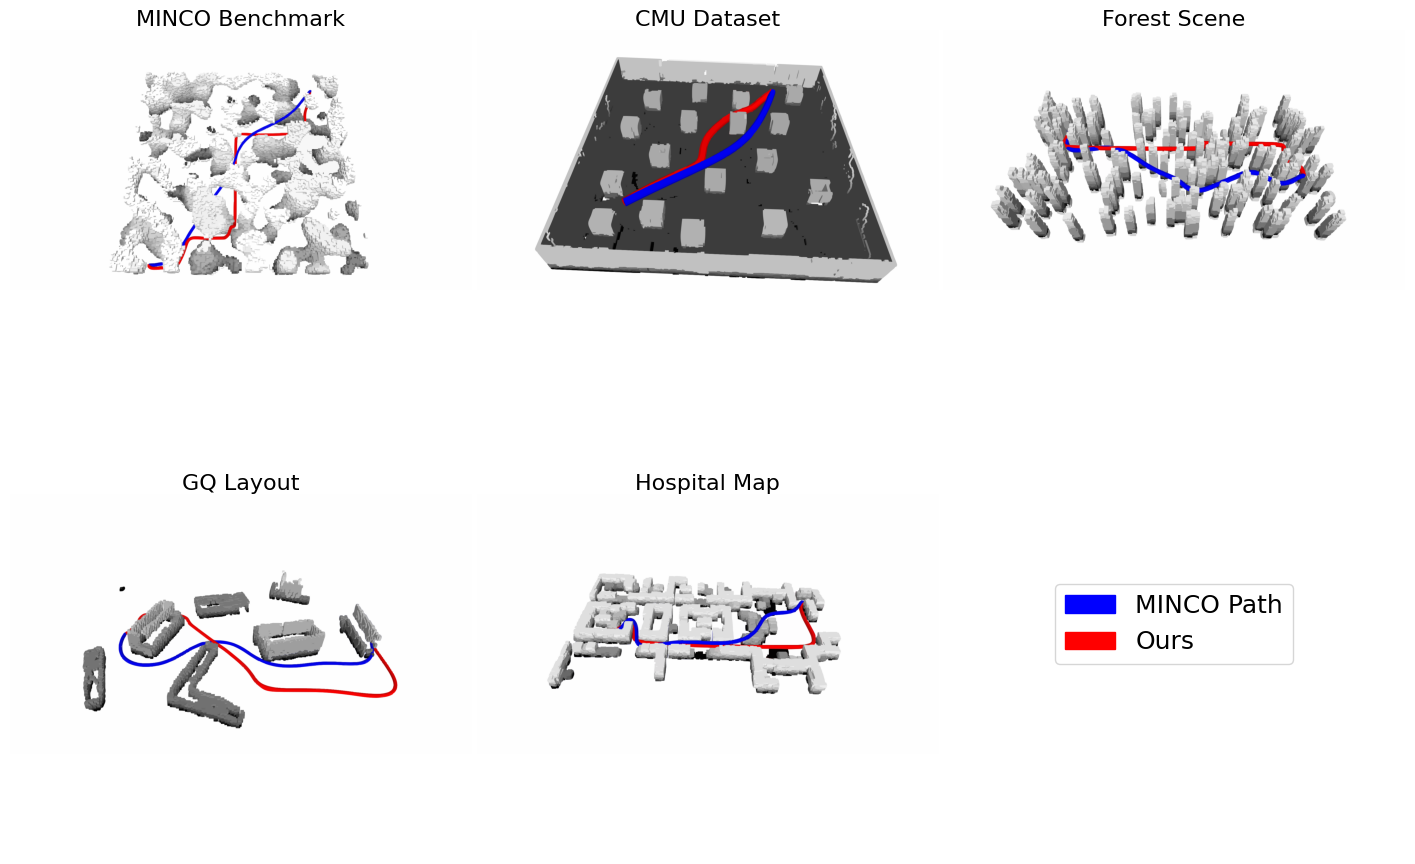

In [20]:
import io
import cairosvg
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
from matplotlib.patches import Patch
from PIL import Image
from matplotlib.gridspec import GridSpec

# Your SVGs + captions
svg_files = [
    '/home/raghuram/Downloads/minco_img.svg',
    '/home/raghuram/Downloads/cmu_img.svg',
    '/home/raghuram/Downloads/forrest_img.svg',
    '/home/raghuram/Downloads/gq_img.svg',
    '/home/raghuram/Downloads/hospital_img.svg'
]
captions = [
    'MINCO Benchmark',
    'CMU Dataset',
    'Forest Scene',
    'GQ Layout',
    'Hospital Map'
]

# Create figure with custom GridSpec for more control
fig = plt.figure(figsize=(18, 12))
gs = GridSpec(2, 3, figure=fig, wspace=0.01, hspace=0.01)

# Process each image
for idx, svg_path in enumerate(svg_files):
    # Calculate grid position (2 rows, 3 cols)
    row = idx // 3
    col = idx % 3
    
    # Convert SVG to PNG bytes at high DPI
    png_bytes = cairosvg.svg2png(url=svg_path, dpi=400)
    
    # Open with PIL, crop to content
    pil_img = Image.open(io.BytesIO(png_bytes)).convert("RGBA")
    bbox = pil_img.getbbox()
    pil_cropped = pil_img.crop(bbox)
    
    # Convert to array for display
    buf = io.BytesIO()
    pil_cropped.save(buf, format='PNG')
    buf.seek(0)
    img = mpimg.imread(buf, format='png')
    
    # Create subplot and display image
    ax = fig.add_subplot(gs[row, col])
    ax.imshow(img)
    ax.set_title(captions[idx], fontsize=16, pad=2)
    ax.axis('off')
    
    # Eliminate internal padding
    ax.set_xticks([])
    ax.set_yticks([])
    for spine in ax.spines.values():
        spine.set_visible(False)

# Add legend in the last cell
legend_ax = fig.add_subplot(gs[1, 2])
legend_ax.axis('off')
legend_handles = [
    Patch(facecolor='blue', edgecolor='blue', label='MINCO Path'),
    Patch(facecolor='red', edgecolor='red', label='Ours')
]
legend_ax.legend(handles=legend_handles, loc='center', fontsize=18)

# Tight layout with minimal padding
plt.tight_layout(pad=0.1)

# Save with maximum quality
fig.savefig(
    'output_figure.pdf',
    format='pdf',
    dpi=600,
    bbox_inches='tight',
    pad_inches=0
)

plt.show()

In [22]:
import io
import cairosvg
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.patches import Rectangle, Patch
from PIL import Image
from matplotlib.gridspec import GridSpec

# --- CONFIG ---

svg_files = [
    '/home/raghuram/Downloads/minco_img.svg',
    '/home/raghuram/Downloads/cmu_img.svg',
    '/home/raghuram/Downloads/forrest_img.svg',
    '/home/raghuram/Downloads/gq_img.svg',
    '/home/raghuram/Downloads/hospital_img.svg'
]
captions = [
    'MINCO Benchmark',
    'CMU Dataset',
    'Forest Scene',
    'GQ Layout',
    'Hospital Map'
]
dpi = 400  # for SVG→PNG conversion

# --- 1) IMAGES PDF ---

fig = plt.figure(figsize=(18, 12))
gs = GridSpec(2, 3, figure=fig, wspace=0.01, hspace=0.01)

for idx, (svg_path, cap) in enumerate(zip(svg_files, captions)):
    row, col = divmod(idx, 3)
    ax = fig.add_subplot(gs[row, col])
    
    # Render & crop
    png = cairosvg.svg2png(url=svg_path, dpi=dpi)
    pil = Image.open(io.BytesIO(png)).convert("RGBA")
    pil = pil.crop(pil.getbbox())
    buf = io.BytesIO()
    pil.save(buf, format='PNG')
    buf.seek(0)
    img = mpimg.imread(buf, format='png')
    
    ax.imshow(img)
    ax.set_title(cap, fontsize=16, pad=2)
    ax.axis('off')
    
    # Double border: outer + inner
    for lw in [4, 2]:  # outer thicker, inner thinner
        rect = Rectangle((0,0),1,1, transform=ax.transAxes,
                         edgecolor='gray', facecolor='none', linewidth=lw)
        ax.add_patch(rect)

# Save images grid
plt.tight_layout(pad=0.1)
fig.savefig(
    'images_only.pdf',
    format='pdf',
    dpi=600,
    bbox_inches='tight',
    pad_inches=0
)
plt.close(fig)

# --- 2) LEGEND PDF ---

fig = plt.figure(figsize=(6, 3))
ax = fig.add_axes([0,0,1,1])
ax.axis('off')

# Legend title bar
ax.add_patch(Rectangle((0,0.8),1,0.2, transform=ax.transAxes,
                       facecolor='#f0f0f0', edgecolor='gray', linewidth=1))
ax.text(0.5, 0.9, 'Legend',
        ha='center', va='center',
        fontname='Times New Roman', fontsize=16)

# Legend entries
handles = [
    Patch(facecolor='blue', edgecolor='blue', label='MINCO Path'),
    Patch(facecolor='red',  edgecolor='red',  label='Ours')
]
ax.legend(handles=handles, loc='center', frameon=False,
          prop={'family':'Times New Roman','size':14}, ncol=2)

# Save legend
fig.savefig(
    'legend_only.pdf',
    format='pdf',
    bbox_inches='tight',
    pad_inches=0
)
plt.close(fig)


/tmp/ipykernel_56859/3112377167.py:56: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(pad=0.1)
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
find

In [60]:
import io
import cairosvg
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image

# --- CONFIG ---
svg_paths = [
    '/home/raghuram/Downloads/minco_img.svg',
    '/home/raghuram/Downloads/cmu_img.svg',
    '/home/raghuram/Downloads/forrest_img.svg',
    '/home/raghuram/Downloads/gq_img.svg',
    '/home/raghuram/Downloads/hospital_img.svg'
]
captions = [
    'Perlin Noise',
    'Parking Lot',
    'Forest ',
    'Town ',
    'Hospital '
]
dpi = 300
images_pdf = 'images_only.pdf'

# Fractional crop shift for bottom row [0.0 .. bot_h_frac+gap_frac]
# 0.0 = no shift,  e.g. bottom row at y=0
# 0.2 = shift up by 20% of figure height
bottom_crop = 0.05  

def load_and_crop(svg_path, dpi=300):
    png = cairosvg.svg2png(url=svg_path, dpi=dpi)
    pil = Image.open(io.BytesIO(png)).convert('RGBA')
    pil = pil.crop(pil.getbbox())
    buf = io.BytesIO(); pil.save(buf, format='PNG'); buf.seek(0)
    arr = mpimg.imread(buf, format='png')
    return pil.size, arr

# Load images
sizes, arrs = zip(*(load_and_crop(p, dpi) for p in svg_paths))

# Compute geometry
w0,h0 = sizes[0]; w1,h1 = sizes[1]; w2,h2 = sizes[2]
w3,h3 = sizes[3]; w4,h4 = sizes[4]
sum_w_top = w0+w1+w2
sum_w_bot = w3+w4
max_top_h = max(h0,h1,h2)
max_bot_h = max(h3,h4)

# Figure size in inches (white background)
fig_w = sum_w_top / dpi
fig_h = (max_top_h + max_bot_h + 0.1*dpi) / dpi

# Fractions
top_h_frac = max_top_h / (max_top_h + max_bot_h + 0.1*dpi)
bot_h_frac = max_bot_h / (max_top_h + max_bot_h + 0.1*dpi)
gap_frac   = (0.1*dpi) / (max_top_h + max_bot_h + 0.1*dpi)

top_ws = [w0/sum_w_top, w1/sum_w_top, w2/sum_w_top]
bot_ws = [w3/sum_w_bot, w4/sum_w_bot]

# --- IMAGES PDF ---
fig = plt.figure(figsize=(fig_w, fig_h), dpi=dpi, facecolor='white')

# Top row
left = 0
for i in range(3):
    w_frac = top_ws[i]
    ax = fig.add_axes([left, bot_h_frac + gap_frac, w_frac, top_h_frac])
    ax.imshow(arrs[i], interpolation='nearest')
    ax.axis('off')
    title_shift = bottom_crop - 0.10# same as the y0 offset
    ax.set_title(
        captions[i],
        fontsize=40,
        y=1 + title_shift,     # axes-fraction: 1 is top of axes, +shift moves with it
        fontname='Times New Roman'
    )
    left += w_frac

# Bottom row (centered + shifted up by bottom_crop)
left = (1 - sum(bot_ws)) / 2
for j in range(2):
    w_frac = bot_ws[j]
    y0 = bottom_crop  # base y-position for bottom row
    ax = fig.add_axes([left, y0, w_frac, bot_h_frac])
    ax.imshow(arrs[3+j], interpolation='nearest')
    ax.axis('off')
    
    # Move the title up by placing it at y = 1 + title_shift
    # title_shift should match how far the axes moved up
    title_shift = bottom_crop - 0.30# same as the y0 offset
    ax.set_title(
        captions[3+j],
        fontsize=40,
        y=1 + title_shift,     # axes-fraction: 1 is top of axes, +shift moves with it
        fontname='Times New Roman'
    )
    
    left += w_frac

    fig.savefig(
    images_pdf,
    format='pdf',
    dpi=dpi,
    bbox_inches='tight',
    pad_inches=0,
    facecolor='white'
    )
    plt.close(fig)

print(f"Saved {images_pdf} ({fig_w:.2f}×{fig_h:.2f} in) with bottom_crop={bottom_crop}")


findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times Ne

Saved images_only.pdf (19.20×7.30 in) with bottom_crop=0.05


In [53]:
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

legend_pdf = 'legend_only.pdf'

# --- LEGEND PDF (ULTRA‑TIGHT) with white background ---
fig = plt.figure(figsize=(4,2), facecolor='white')
ax = fig.add_axes([0,0,1,1])
ax.axis('off')

# Create legend with 2 columns
handles = [
    Patch(facecolor='blue', edgecolor='blue', label='MINCO Path'),
    Patch(facecolor='red',  edgecolor='red',  label='Ours')
]
legend = ax.legend(
    handles=handles,
    loc='center',
    frameon=False,
    ncol=2,
    prop={'family':'Times New Roman','size':14}
)

# Draw canvas to compute bounding box
fig.canvas.draw()

# Get legend bounding box in inches
bbox = legend.get_window_extent().transformed(fig.dpi_scale_trans.inverted())

# Save only that area with white background
fig.savefig(
    legend_pdf,
    format='pdf',
    bbox_inches=bbox,
    pad_inches=0,
    facecolor='white'
)
plt.close(fig)

print(f"Saved ultra‑tight legend to {legend_pdf}")


findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times Ne

Saved ultra‑tight legend to legend_only.pdf


In [67]:
#!/usr/bin/env python3
"""
Extract point cloud and paths from ROS2 bag files (using only the last message from each topic),
export to a GLB file, and display it in an IPython Notebook.

The point cloud is simulated as a set of small boxes (with adjustable size)
colored in grayscale based on their z height.
Path1 is colored red and path2 is colored blue.
If the point cloud is too large, it will be subsampled to avoid overloading the system.
Ground points (with z below a threshold) are removed for a cleaner point cloud.
"""

import numpy as np
import trimesh
import rosbag2_py
from rclpy.serialization import deserialize_message  # Updated import for ROS2 Humble
from sensor_msgs.msg import PointCloud2
from nav_msgs.msg import Path
import sensor_msgs_py.point_cloud2 as pc2

# For displaying in an IPython Notebook
from IPython.display import HTML, display

def extract_point_cloud(bag_path, topic):
    """Extract the point cloud data (x, y, z) from only the last message in the bag file for the given topic."""
    reader = rosbag2_py.SequentialReader()
    storage_options = rosbag2_py.StorageOptions(uri=bag_path, storage_id='sqlite3')
    converter_options = rosbag2_py.ConverterOptions(
        input_serialization_format='cdr',
        output_serialization_format='cdr'
    )
    reader.open(storage_options, converter_options)

    last_data = None
    while reader.has_next():
        topic_name, data, t = reader.read_next()
        if topic_name == topic:
            last_data = data
    if last_data is None:
        return np.array([])

    msg = deserialize_message(last_data, PointCloud2)
    points = []
    for p in pc2.read_points(msg, skip_nans=True, field_names=("x", "y", "z")):
        points.append(p)
    return np.array(points)

def extract_path(bag_path, topic):
    """Extract the path (as a set of poses) from only the last message from the bag file for the given topic."""
    reader = rosbag2_py.SequentialReader()
    storage_options = rosbag2_py.StorageOptions(uri=bag_path, storage_id='sqlite3')
    converter_options = rosbag2_py.ConverterOptions(
        input_serialization_format='cdr',
        output_serialization_format='cdr'
    )
    reader.open(storage_options, converter_options)

    last_data = None
    while reader.has_next():
        topic_name, data, t = reader.read_next()
        if topic_name == topic:
            last_data = data
    if last_data is None:
        return np.array([])

    msg = deserialize_message(last_data, Path)
    path_points = []
    for pose_stamped in msg.poses:
        pos = pose_stamped.pose.position
        path_points.append([pos.x, pos.y, pos.z])
    return np.array(path_points)

def create_path_cylinders(path_points, radius=0.05):
    """
    Create a single mesh that represents the path as a series of cylinders
    connecting consecutive waypoints.
    """
    cylinders = []
    for i in range(len(path_points) - 1):
        start = path_points[i]
        end = path_points[i + 1]
        vec = end - start
        length = np.linalg.norm(vec)
        if length == 0:
            continue
        # Create a cylinder along the Z axis (centered at origin)
        cyl = trimesh.creation.cylinder(radius=radius, height=length, sections=12)
        # Align the cylinder with the vector from start to end.
        z_axis = np.array([0, 0, 1])
        direction = vec / length
        rotation, _ = trimesh.geometry.align_vectors(z_axis, direction, return_angle=True)
        T = trimesh.transformations.translation_matrix((start + end) / 2)
        transform = trimesh.transformations.concatenate_matrices(T, rotation)
        cyl.apply_transform(transform)
        cylinders.append(cyl)
    if cylinders:
        return trimesh.util.concatenate(cylinders)
    else:
        return None

def create_point_cloud_mesh(points, colors, point_size=0.02):
    """
    Create a mesh representing the point cloud by instancing a small box
    at each point.
    
    Args:
      points (Nx3 array): XYZ coordinates.
      colors (Nx4 array): RGBA colors for each point (values in 0-255).
      point_size (float): Edge length of the box representing each point.
    
    Returns:
      A trimesh.Trimesh object containing all the box instances.
    """
    # Create a box template centered at the origin.
    box = trimesh.creation.box(extents=[point_size, point_size, point_size])
    meshes = []
    for pt, color in zip(points, colors):
        instance = box.copy()
        instance.visual.face_colors = color
        instance.apply_translation(pt)
        meshes.append(instance)
    return trimesh.util.concatenate(meshes)

def display_glb(glb_filename):
    """Display the GLB file in an IPython Notebook using <model-viewer>."""
    html_code = f"""
    <script type="module" src="https://unpkg.com/@google/model-viewer/dist/model-viewer.min.js"></script>
    <model-viewer src="{glb_filename}" alt="3D model" auto-rotate camera-controls style="width: 800px; height: 600px;"></model-viewer>
    """
    display(HTML(html_code))

def main():
    # Define bag file paths and corresponding topics
    pc_bag    = "/media/raghuram/Untitled/bags/ros2_bags/map_VIO_indoors/map_escape_dead_end"
    pc_topic  = "/race16/visual_pc"
    path1_bag = "/media/raghuram/Untitled/bags/ros2_bags/map_VIO_indoors/map_escape_dead_end"
    path1_topic = "/race16/quadrotor_path"
    # path2_bag = "/media/raghuram/Untitled/bags/ros2_bags/cmu_map_ros2"
    # path2_topic = "/visualizer/trajectory_path"

    # Adjustable parameters
    point_size = 0.2
    max_points = 50000  # Limit the number of point cloud boxes to process
    ground_threshold = 0  # Remove points with z <= ground_threshold

    print("Extracting point cloud from:", pc_bag)
    points = extract_point_cloud(pc_bag, pc_topic)
    print(f"Extracted {points.shape[0]} points from the last message.")

    # Convert structured array to a regular (N,3) float64 array if needed.
    if points.size > 0 and points.dtype.names is not None:
        points = np.stack((points['x'], points['y'], points['z']), axis=-1).astype(np.float64)

    # Subsample the points if there are too many.
    if points.shape[0] > max_points:
        indices = np.random.choice(points.shape[0], max_points, replace=False)
        points = points[indices]
        print(f"Subsampled to {points.shape[0]} points.")
    
    # Remove ground points (those with z value below the threshold)
    if points.size > 0:
        points = points[points[:,2] > ground_threshold]
        print(f"After ground removal, {points.shape[0]} points remain.")

    print("Extracting path1 from:", path1_bag)
    path1_points = extract_path(path1_bag, path1_topic)
    print(f"Extracted {path1_points.shape[0]} waypoints for path1 from the last message.")

    # print("Extracting path2 from:", path2_bag)
    # path2_points = extract_path(path2_bag, path2_topic)
    # print(f"Extracted {path2_points.shape[0]} waypoints for path2 from the last message.")

    # Build a trimesh scene to hold all geometry.
    scene = trimesh.Scene()

    # Create and add the point cloud mesh with grayscale intensity based on z height.
    if points.size > 0:
        z = points[:, 2]
        z_min, z_max = z.min(), z.max()
        normalized = np.zeros_like(z) if np.isclose(z_max, z_min) else (z - z_min) / (z_max - z_min)

        blue = (normalized * 255 -255 ).astype(np.uint8)
        alpha = np.full_like(blue, 255, dtype=np.uint8)
        rgba = np.stack([np.zeros_like(blue),
                         np.zeros_like(blue),
                         blue,
                         alpha], axis=1)

        point_cloud_mesh = create_point_cloud_mesh(points, rgba, point_size=point_size)
        scene.add_geometry(point_cloud_mesh, node_name='point_cloud')
    
    # Create and add path geometries if available.
    if path1_points.shape[0] > 1:
        path1_mesh = create_path_cylinders(path1_points, radius=0.3)
        if path1_mesh is not None:
            # Color path1 in red (RGBA)
            path1_mesh.visual.face_colors = [255, 0, 0, 255]
            scene.add_geometry(path1_mesh, node_name='path1')
    # if path2_points.shape[0] > 1:
    #     path2_mesh = create_path_cylinders(path2_points, radius=0.3)
    #     if path2_mesh is not None:
    #         # Color path2 in light blue (RGBA)
    #         path2_mesh.visual.face_colors = [0, 0, 230, 255]
    #         scene.add_geometry(path2_mesh, node_name='path2')
    
    # Export the scene to a GLB (glTF binary) file.
    output_file = "/media/raghuram/Untitled/glb/output_vio_v1.glb"
    scene.export(output_file)
    print(f"Scene exported successfully to {output_file}")

    # Display the GLB in the IPython Notebook.
    display_glb(output_file)#!/usr/bin/env python3



if __name__ == "__main__":
    main()


Extracting point cloud from: /media/raghuram/Untitled/bags/ros2_bags/map_VIO_indoors/map_escape_dead_end
Extracted 38022 points from the last message.
After ground removal, 21926 points remain.
Extracting path1 from: /media/raghuram/Untitled/bags/ros2_bags/map_VIO_indoors/map_escape_dead_end
Extracted 202 waypoints for path1 from the last message.


[INFO] [1744137219.876883266] [rosbag2_storage]: Opened database '/media/raghuram/Untitled/bags/ros2_bags/map_VIO_indoors/map_escape_dead_end/rosbag2_2025_04_04-16_33_39_0.db3' for READ_ONLY.
[INFO] [1744137219.965884050] [rosbag2_storage]: Opened database '/media/raghuram/Untitled/bags/ros2_bags/map_VIO_indoors/map_escape_dead_end/rosbag2_2025_04_04-16_33_39_0.db3' for READ_ONLY.


Scene exported successfully to /media/raghuram/Untitled/glb/output_vio_v1.glb


In [ ]:
#!/usr/bin/env python3
"""
Extract point cloud and paths from ROS2 bag files (using only the last message from each topic),
export to a GLB file, and display it in an IPython Notebook.

The point cloud is simulated as a set of small boxes (with adjustable size)
colored in blue intensity based on their z height.
Path1 is colored red.
Ground points (with z below a threshold) are removed for a cleaner point cloud.
Z axis is scaled to exaggerate height differences.
"""

import numpy as np
import trimesh
import rosbag2_py
from rclpy.serialization import deserialize_message
from sensor_msgs.msg import PointCloud2
from nav_msgs.msg import Path
import sensor_msgs_py.point_cloud2 as pc2
from IPython.display import HTML, display

def extract_point_cloud(bag_path, topic):
    """Extract the point cloud data (x, y, z) from only the last message in the bag file for the given topic."""
    reader = rosbag2_py.SequentialReader()
    storage_options = rosbag2_py.StorageOptions(uri=bag_path, storage_id='sqlite3')
    converter_options = rosbag2_py.ConverterOptions(
        input_serialization_format='cdr',
        output_serialization_format='cdr'
    )
    reader.open(storage_options, converter_options)

    last_data = None
    while reader.has_next():
        topic_name, data, t = reader.read_next()
        if topic_name == topic:
            last_data = data
    if last_data is None:
        return np.empty((0, 3), dtype=np.float64)

    msg = deserialize_message(last_data, PointCloud2)
    pts = list(pc2.read_points(msg, skip_nans=True, field_names=("x", "y", "z")))
    if not pts:
        return np.empty((0, 3), dtype=np.float64)

    arr = np.array(pts)
    # If it's structured, stack fields; else it's already (N,3)
    if arr.dtype.names:
        return np.vstack([arr['x'], arr['y'], arr['z']]).T.astype(np.float64)
    else:
        return arr.astype(np.float64)


def extract_path(bag_path, topic):
    reader = rosbag2_py.SequentialReader()
    storage_options = rosbag2_py.StorageOptions(uri=bag_path, storage_id='sqlite3')
    converter_options = rosbag2_py.ConverterOptions('cdr','cdr')
    reader.open(storage_options, converter_options)
    last_data = None
    while reader.has_next():
        name, data, _ = reader.read_next()
        if name == topic:
            last_data = data
    if last_data is None:
        return np.empty((0,3))
    msg = deserialize_message(last_data, Path)
    pts = []
    for ps in msg.poses:
        p = ps.pose.position
        pts.append([p.x, p.y, p.z])
    return np.array(pts, dtype=np.float64)

def create_path_cylinders(path_points, radius=0.05):
    cylinders = []
    for i in range(len(path_points)-1):
        A, B = path_points[i], path_points[i+1]
        vec = B - A
        L = np.linalg.norm(vec)
        if L < 1e-6: continue
        cyl = trimesh.creation.cylinder(radius=radius, height=L, sections=12)
        direction = vec / L
        R, _ = trimesh.geometry.align_vectors([0,0,1], direction, return_angle=True)
        T = trimesh.transformations.translation_matrix((A+B)/2)
        cyl.apply_transform(trimesh.transformations.concatenate_matrices(T, R))
        cylinders.append(cyl)
    return trimesh.util.concatenate(cylinders) if cylinders else None

def create_point_cloud_mesh(points, colors, point_size=0.02):
    box = trimesh.creation.box(extents=[point_size]*3)
    meshes = []
    for p, c in zip(points, colors):
        inst = box.copy()
        inst.visual.face_colors = c
        inst.apply_translation(p)
        meshes.append(inst)
    return trimesh.util.concatenate(meshes)

def display_glb(glb_path):
    html = f"""
    <script type="module" src="https://unpkg.com/@google/model-viewer/dist/model-viewer.min.js"></script>
    <model-viewer src="{glb_path}" alt="3D model" auto-rotate camera-controls
      style="width:800px; height:600px;"></model-viewer>
    """
    display(HTML(html))

def main():
    # Bag paths & topics
    pc_bag    = "/media/raghuram/Untitled/bags/ros2_bags/map_VIO_indoors/map_escape_dead_end"
    pc_topic  = "/race16/visual_pc"
    path1_bag = "/media/raghuram/Untitled/bags/ros2_bags/map_VIO_indoors/map_escape_dead_end"
    path1_topic = "/race16/quadrotor_path"
    output_file = "/media/raghuram/Untitled/glb/output_vio_v1.glb"

    # Adjustable parameters
    point_size      = 0.2
    max_points      = 50000
    ground_threshold = 0.0
    z_scale         = 2.0  # <-- scale Z axis by this factor

    # Extract and preprocess point cloud
    points = extract_point_cloud(pc_bag, pc_topic)
    if points.size and points.dtype.names:
        points = np.stack((points['x'], points['y'], points['z']), axis=-1)
    # Remove ground
    points = points[points[:,2] > ground_threshold]
    # Subsample
    if points.shape[0] > max_points:
        idx = np.random.choice(points.shape[0], max_points, replace=False)
        points = points[idx]
    # Scale Z
    points[:,2] *= z_scale

    # Extract and preprocess path1
    path1 = extract_path(path1_bag, path1_topic)
    # Remove segments below ground
    if path1.shape[0] > 1:
        above = path1[:,2] > ground_threshold
        keep = np.logical_and(above[:-1], above[1:])
        idxs = np.where(keep)[0]
        valid = np.unique(np.concatenate([idxs, idxs+1]))
        valid = valid[valid < path1.shape[0]]
        path1 = path1[valid]
    # Scale Z
    path1[:,2] *= z_scale

    # Build scene
    scene = trimesh.Scene()

    # Color by blue intensity
    if points.size:
        # Define your light‑blue RGBA once
        light_blue = np.array([200, 216, 255, 255], dtype=np.uint8)
        # Create an (N,4) array where every row is that color
        rgba = np.tile(light_blue, (points.shape[0], 1))

        pcm = create_point_cloud_mesh(points, rgba, point_size=point_size)
        scene.add_geometry(pcm, 'point_cloud')


    # Add path1 in red
    if path1.shape[0] > 1:
        m1 = create_path_cylinders(path1, radius=0.3)
        if m1:
            m1.visual.face_colors = [255,0,0,255]
            scene.add_geometry(m1, 'path1')

    # Export & display
    scene.export(output_file)
    display_glb(output_file)

if __name__ == "__main__":
    main()


[INFO] [1744137746.008553852] [rosbag2_storage]: Opened database '/media/raghuram/Untitled/bags/ros2_bags/map_VIO_indoors/map_escape_dead_end/rosbag2_2025_04_04-16_33_39_0.db3' for READ_ONLY.
[INFO] [1744137746.095073465] [rosbag2_storage]: Opened database '/media/raghuram/Untitled/bags/ros2_bags/map_VIO_indoors/map_escape_dead_end/rosbag2_2025_04_04-16_33_39_0.db3' for READ_ONLY.
